Siu expression autocompletion: _.cyl.\<tab\>
==========================================

Note: this is document is based on [PR 248](https://github.com/machow/siuba/pull/248) by [@tmastny](https://github.com/tmastny), and all the discussion there!

(Drafted on 7 August 2020)

tl;dr. Implementing autocompletion requires 3 components: identifying the DataFrame to complete, understanding IPython autocompletion, and plugging in to it. The approach we took is to use a user's execution history to identify the DataFrame, and to modify `IPCompleter._jedi_matches`. As discussed in this [PR](https://github.com/machow/siuba/pull/258), a useful approach in the future would be to use a simple regex, like RStudio does.

## Problem

The `_` is meant as a lazy way of representing your data.
Currently, a user autocompleting with _.\<tab\> will not receive suggestions for the data they have in mind.



After importing siuba's mtcars data, a user might want to filter by cylinder, but forget its exact name.

Autocomplete to the rescue! They'd be able to press tab to receive handy suggestions, including column names.

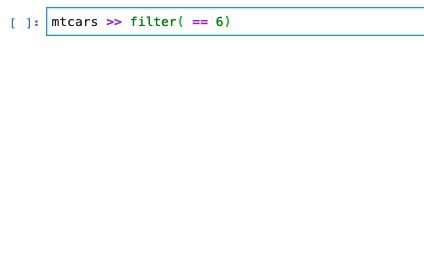

**While an exciting feature, this requires solving hard problems**. There are significant technical challenges related to (1) getting the DataFrame to complete, and (2) plugging into the autocomplete architecture.

For example, the most common approach used for autocompletion--and one used by pandas--is to define a `__dir__` method.
This method then lists out everything you want the user to see when they autocomplete.

However, because the `_` object doesn't know anything about DataFrames, it doesn't return anything useful.

In [1]:
from siuba.siu import _

dir(_)[:6]

['_Symbolic__op_invert',
 '_Symbolic__ready_to_call',
 '_Symbolic__source',
 '__abs__',
 '__add__',
 '__and__']

In this ADR, I will review how we can find the right DataFrame to autocomplete, the state of autocompletion in IPython, and three potential solutions.

## Key questions

I'll review each of these questions below.

* **framing**: How do we know what DataFrame (e.g. mtcars) the user wants completions for?
* **IPython autocompletion**: What are the key technical hurdles in the existing autocomplete API?
* **glory road**: What are three ways to get completions like in the gif?

## Framing: what DataFrame are users looking for?

Two possibilities come to mind:

1. The DataFrame being used at the start of a pipe.
2. The last DataFrame they defined or used.





### Start of a pipe

```python
(mtcars
  >> filter(_.<tab> == 6)        # note the tab!
  >> mutate(hp2 = _.hp*2)
)
```

A big challenge here is that this code is not valid python (since it has `_. == 6`). We would likely need to use regex to analyze it. Alternatively, looking at the code they've already run, rather then the code they're on, might be a better place to start.


### Last defined or used

The last defined or used DataFrame is likely impossible to identify, since it'd require knowing the order variables get defined and accessed. However, **static analysis of code history** would let us take a guess. For example, the code below shows some different cases. In each case, we could pick the mtcars or cars2 is being used.

```python
# import mtcars
from siuba.data import mtcars

# assign cars2
cars2 = mtcars

# attribute access cars2
cars2.cyl + 1
```



In [2]:
import ast

class FrameDetector(ast.NodeVisitor):
    def __init__(self):
        self.results = []
        super().__init__()
        
    def visit_Name(self, node):
        # visit any children
        self.generic_visit(node)
        
        # store name as a result
        self.results.append(node.id)

visitor = FrameDetector()

visitor.visit(ast.parse("""
from siuba.data import mtcars
cars2 = mtcars + 1
"""))

visitor.results

['cars2', 'mtcars']

The tree is traversed depth first, and can be dumped out for inspection. See [greentreesnakes](https://greentreesnakes.readthedocs.io/en/latest/) for a nice python AST primer.

In [3]:
ast.dump(ast.parse("cars2 = mtcars"))

"Module(body=[Assign(targets=[Name(id='cars2', ctx=Store())], value=Name(id='mtcars', ctx=Load()))])"

Just knowing the variable names is not enough. We also need to know **which ones are DataFrames**.  For our guess, we can use what type of object a variable is at the time the user pressed tab (may differ from when the code is run!).

Here is an example of one way that can be done in IPython.

In [4]:
import pandas as pd

shell = get_ipython()
[k for k,v in shell.user_ns.items() if isinstance(v, pd.DataFrame)]

[]

Last DataFrame defined or used seems ideal!

Once we know the DataFrame the user has in mind, we need to work it into the autocompletion machinery somehow, so that `_.<tab>` returns the same results as if that DataFrame were being autocompleted.

## IPython Autocompletion

This section will go into great detail about how IPython's autocomplete works, to set the stage for technical solutions. Essentially, when a user interacts with autocompletion, there are 3 main libraries involved: ipykernel, IPython, and jedi. This is shown in the dependency graph below.

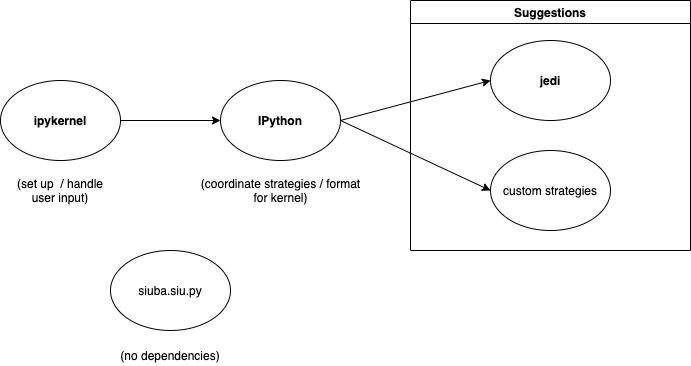

Essentially, our challenge is figuring how where autocomplete could fit in. Just to set the stage, the IPython IPCompleter uses some of its own useful completion strategies, but the bulk of where we benefit comes from its use of the library jedi.

In the sections below, I'll first give a quick preview of how jedi works, followed by two sequence diagrams of how it's intergrated into the ipykernel.

### Jedi completion

At it's core, jedi is easy to use, and does a mix of static analysis and object evaluation. It's super handy!

The code below shows how it might autocomplete a DataFrame called `zzz`, where we define `zzz` to really be the `mtcars` data.

In [5]:
import jedi
from siuba.data import mtcars

interpreter = jedi.Interpreter('zzz.m', [{'zzz': mtcars}])
completions = list(interpreter.complete())

entry = completions[0]
entry, entry.type

(<Completion: mad>, 'function')

Notice that it knows the suggestion `mad` is a function! For a column of the data, it knows that it's not a function, but an instance.

The IPython shell has an instance of it's IPCompleter class, and it's `_jedi_matches` method is responsible for doing the jedi stuff.

In [6]:
from siuba.data import mtcars
shell = get_ipython()

df_auto = list(shell.Completer._jedi_matches(7, 0, "mtcars."))

df_auto[:5]

[<Completion: abs>,
 <Completion: add>,
 <Completion: add_prefix>,
 <Completion: add_suffix>,
 <Completion: agg>]

While this simple description captures the main thrust of how autocomplete works, the full dynamics include some more features such as entry hooks, and some shuffling things around (since the IPCompleter is deprecating its old methods for completing).

The sequence diagrams below show how the kernel sets up autocomplete, and how a specific autocomplete event is run.

Links to code used for diagrams:

* [ipykernel 5.3.4](https://github.com/ipython/ipykernel/blob/5.3.4/ipykernel/ipkernel.py#L64)
* [IPython 7.17.0 - completer.py](https://github.com/ipython/ipython/blob/7.17.0/IPython/core/completer.py#L1861)
* [IPython interactive shell](https://github.com/ipython/ipython/blob/7.17.0/IPython/core/interactiveshell.py#L676)


#### IPython hooks

ipykernel sets everything up, and also exposes methods for using IPCompleter hooks.


[![](https://mermaid.ink/img/eyJjb2RlIjoic2VxdWVuY2VEaWFncmFtXG4gIGlweWtlcm5lbC0-PmlweWtlcm5lbDogU0VUVVBcbiAgaXB5a2VybmVsLT4-K0ludGVyYWN0aXZlU2hlbGw6IHNlbGYuc2hlbGwgPSBfX2luaXRfXyguLi4pXG4gIEludGVyYWN0aXZlU2hlbGwtPj5JbnRlcmFjdGl2ZVNoZWxsOiBpbml0X2NvbXBsZXRlcigpXG4gIEludGVyYWN0aXZlU2hlbGwtPj5JUENvbXBsZXRlcjogX19pbml0X18oc2hlbGw9c2VsZiwgLi4uKVxuICBJbnRlcmFjdGl2ZVNoZWxsLT4-SVBDb21wbGV0ZXI6IHNldCBjdXN0b21fY29tcGxldGVycyA9IFN0ckRpc3BhdGNoKClcbiAgSW50ZXJhY3RpdmVTaGVsbC0-PkludGVyYWN0aXZlU2hlbGw6IHNldF9ob29rKCdjb21wbGV0ZV9jb21tYW5kJywgLi4uKVxuICBJbnRlcmFjdGl2ZVNoZWxsLS0-Pi1pcHlrZXJuZWw6IC5cbiAgIiwibWVybWFpZCI6eyJ0aGVtZSI6ImRlZmF1bHQifSwidXBkYXRlRWRpdG9yIjpmYWxzZX0)](https://mermaid-js.github.io/mermaid-live-editor/#/edit/eyJjb2RlIjoic2VxdWVuY2VEaWFncmFtXG4gIGlweWtlcm5lbC0-PmlweWtlcm5lbDogU0VUVVBcbiAgaXB5a2VybmVsLT4-K0ludGVyYWN0aXZlU2hlbGw6IHNlbGYuc2hlbGwgPSBfX2luaXRfXyguLi4pXG4gIEludGVyYWN0aXZlU2hlbGwtPj5JbnRlcmFjdGl2ZVNoZWxsOiBpbml0X2NvbXBsZXRlcigpXG4gIEludGVyYWN0aXZlU2hlbGwtPj5JUENvbXBsZXRlcjogX19pbml0X18oc2hlbGw9c2VsZiwgLi4uKVxuICBJbnRlcmFjdGl2ZVNoZWxsLT4-SVBDb21wbGV0ZXI6IHNldCBjdXN0b21fY29tcGxldGVycyA9IFN0ckRpc3BhdGNoKClcbiAgSW50ZXJhY3RpdmVTaGVsbC0-PkludGVyYWN0aXZlU2hlbGw6IHNldF9ob29rKCdjb21wbGV0ZV9jb21tYW5kJywgLi4uKVxuICBJbnRlcmFjdGl2ZVNoZWxsLS0-Pi1pcHlrZXJuZWw6IC5cbiAgIiwibWVybWFpZCI6eyJ0aGVtZSI6ImRlZmF1bHQifSwidXBkYXRlRWRpdG9yIjpmYWxzZX0)

(Note that InteractiveShell and IPCompleter come from IPython)

A key here is that one hook, set by the `set_hooks` method is configured using something called `StrDispatch`


In [7]:
from IPython.utils.strdispatch import StrDispatch

dis = StrDispatch()

dis.add_s('hei', lambda: 1)
dis.add_re('_\\..*', lambda: 2)

# must be exactly hei
list(dis.flat_matches('hei'))

[<function __main__.<lambda>()>]

This let's you set hooks that only fire when a specific match is in the code being completed. For example...

In [8]:
# needs to match regex abc.*
list(dis.flat_matches('_.abc'))

[<function __main__.<lambda>()>]

For example, the code below should make `_.a<tab>` complete to `_.ab`.

In [9]:
shell = get_ipython()
shell.set_hook('complete_command', lambda shell, event: ['_.ab'], re_key = '_\\.a.*')

This would be a really promising avenue. However, as I'll show in the next section, hooks must return a list of strings, so cannot give the nice color info with completions, even if they use jedi under the hood.

#### IPython _jedi_matches

The following diagrams illustrates what the path through a single autocompletion event (e.g. pressing tab) looks like. Note that because IPCompleter is transitioning to a new setup, there is some shuffling around that goes on (e.g. do_complete calls _experimental_do_complete, etc..).

[![](https://mermaid.ink/img/eyJjb2RlIjoic2VxdWVuY2VEaWFncmFtXG4gIFxuICBcbiAgaXB5a2VybmVsLT4-aXB5a2VybmVsOiBkb19jb21wbGV0ZShjb2RlLCAuLi4pXG4gIGlweWtlcm5lbC0-PmlweWtlcm5lbDogX2V4cHJpbWVudGFsX2RvX2NvbXBsZXRlKGNvZGUsIC4uLilcblxuICBwYXJ0aWNpcGFudCBJbnRlcmFjdGl2ZVNoZWxsXG5cbiAgaXB5a2VybmVsLT4-SVBDb21wbGV0ZXI6IGNvbXBsZXRpb25zKC4uLilcbiAgSVBDb21wbGV0ZXItPj5JUENvbXBsZXRlcjogX2NvbXBsZXRpb25zKC4uLilcbiAgSVBDb21wbGV0ZXItPj4rSVBDb21wbGV0ZXI6IF9jb21wbGV0ZSguLi4pXG4gIElQQ29tcGxldGVyLT4-K0lQQ29tcGxldGVyOiBfamVkaV9tYXRjaGVzKC4uLilcbiAgSVBDb21wbGV0ZXItPj5qZWRpLkludGVycHJldGVyOiBfX2luaXRfXyguLi4pXG4gIG5vdGUgb3ZlciBqZWRpLkludGVycHJldGVyOiBoYXMgc2hlbGwgbmFtZXNwYWNlXG4gIElQQ29tcGxldGVyLT4-LWplZGkuSW50ZXJwcmV0ZXI6IGNvbXBsZXRpb25zKClcbiAgbm90ZSBvdmVyIElQQ29tcGxldGVyOiBjdXN0b20gaG9va3MgKG11c3QgcmV0dXJuIExpc3Rbc3RyXSlcbiAgSVBDb21wbGV0ZXItPj5JUENvbXBsZXRlcjogbWF0Y2ggdy8gc2VsZi5tYXRjaGVycyAoZS5nLiBob29rcylcbiAgSVBDb21wbGV0ZXItPj4tSVBDb21wbGV0ZXI6IGRpc3BhdGNoX2N1c3RvbV9jb21wbGV0ZXIodGV4dClcbiAgbm90ZSBvdmVyIElQQ29tcGxldGVyOiBob29rcyBtdXN0IHJldHVybiBzdHJpbmdzLCBzbyBubyB0eXBlIGluZm9cbiAgSVBDb21wbGV0ZXItPj5JUENvbXBsZXRlcjogcHJvY2VzcyBtYXRjaGVzLCB3cmFwIGluIENvbXBsZXRpb25cblxuICBcbiAgSVBDb21wbGV0ZXItLT4-aXB5a2VybmVsOiBJdGVyW0NvbXBsZXRpb25dXG5cbiIsIm1lcm1haWQiOnsidGhlbWUiOiJkZWZhdWx0In0sInVwZGF0ZUVkaXRvciI6ZmFsc2V9)](https://mermaid-js.github.io/mermaid-live-editor/#/edit/eyJjb2RlIjoic2VxdWVuY2VEaWFncmFtXG4gIFxuICBcbiAgaXB5a2VybmVsLT4-aXB5a2VybmVsOiBkb19jb21wbGV0ZShjb2RlLCAuLi4pXG4gIGlweWtlcm5lbC0-PmlweWtlcm5lbDogX2V4cHJpbWVudGFsX2RvX2NvbXBsZXRlKGNvZGUsIC4uLilcblxuICBwYXJ0aWNpcGFudCBJbnRlcmFjdGl2ZVNoZWxsXG5cbiAgaXB5a2VybmVsLT4-SVBDb21wbGV0ZXI6IGNvbXBsZXRpb25zKC4uLilcbiAgSVBDb21wbGV0ZXItPj5JUENvbXBsZXRlcjogX2NvbXBsZXRpb25zKC4uLilcbiAgSVBDb21wbGV0ZXItPj4rSVBDb21wbGV0ZXI6IF9jb21wbGV0ZSguLi4pXG4gIElQQ29tcGxldGVyLT4-K0lQQ29tcGxldGVyOiBfamVkaV9tYXRjaGVzKC4uLilcbiAgSVBDb21wbGV0ZXItPj5qZWRpLkludGVycHJldGVyOiBfX2luaXRfXyguLi4pXG4gIG5vdGUgb3ZlciBqZWRpLkludGVycHJldGVyOiBoYXMgc2hlbGwgbmFtZXNwYWNlXG4gIElQQ29tcGxldGVyLT4-LWplZGkuSW50ZXJwcmV0ZXI6IGNvbXBsZXRpb25zKClcbiAgbm90ZSBvdmVyIElQQ29tcGxldGVyOiBjdXN0b20gaG9va3MgKG11c3QgcmV0dXJuIExpc3Rbc3RyXSlcbiAgSVBDb21wbGV0ZXItPj5JUENvbXBsZXRlcjogbWF0Y2ggdy8gc2VsZi5tYXRjaGVycyAoZS5nLiBob29rcylcbiAgSVBDb21wbGV0ZXItPj4tSVBDb21wbGV0ZXI6IGRpc3BhdGNoX2N1c3RvbV9jb21wbGV0ZXIodGV4dClcbiAgbm90ZSBvdmVyIElQQ29tcGxldGVyOiBob29rcyBtdXN0IHJldHVybiBzdHJpbmdzLCBzbyBubyB0eXBlIGluZm9cbiAgSVBDb21wbGV0ZXItPj5JUENvbXBsZXRlcjogcHJvY2VzcyBtYXRjaGVzLCB3cmFwIGluIENvbXBsZXRpb25cblxuICBcbiAgSVBDb21wbGV0ZXItLT4-aXB5a2VybmVsOiBJdGVyW0NvbXBsZXRpb25dXG5cbiIsIm1lcm1haWQiOnsidGhlbWUiOiJkZWZhdWx0In0sInVwZGF0ZUVkaXRvciI6ZmFsc2V9)

Intriguingly, ipykernel also jumps over InteractiveShell, accessing the shell's Completer instance directly. Then, essentially 3 critical steps are run: jedi completions, two kinds of hooks, and wrapping each result in a simple Completion class.

## Glory road: three technical solutions

Essentially, the dynamics described above leave us with three potential solutions for autocomplete:

* hooks (without type info)
* modify siu's `Symbolic.__dir__` method
* monkey patch Completer's _jedi_matches method

To foreshadow, the last is the only one that will give us those sweet colored type annotations, so is preferred!

### Option 1: IPython.Completer hooks

While hooks are an interesting approach, they currently require you to return a list of strings. Only `Completer._jedi_matches` can return the enriched suggestions, and it requires strings from hooks.

(**NOTE:** if you make changes to the code below, you may need to restart your kernel and re-run the cell's code.)

In [10]:
#TODO: make workable
from siuba.data import mtcars
from siuba import _
import sys

# will use zzz.<tab> for this example
zzz = _


def hook(shell, event):
    # change the completers namespace, then change it back at the end
    # would likely need to be done in a context manager, down the road!
    old_ns = shell.Completer.namespace
    
    target_df = shell.user_ns["mtcars"]
    shell.Completer.namespace = {**old_ns, "zzz": target_df}

    # then, run completion method
    col_num, line_num = len(event.symbol), 0
    completions = shell.Completer._jedi_matches(col_num, line_num, event.symbol)

    # change namespace back
    shell.Completer.namespace = old_ns

    # get suggestions
    suggestions = [event.command +  x.name for x in completions]

    # should be able to see these in the terminal for debugging
    with  open('/dev/stdout', 'w') as f:
        print(suggestions, file = f)
        
    return suggestions

shell = get_ipython()
shell.set_hook('complete_command', hook, re_key = '.*zzz.*')

In [11]:
# uncomment and press tab
#zzz.

<div style="width: 200px;">

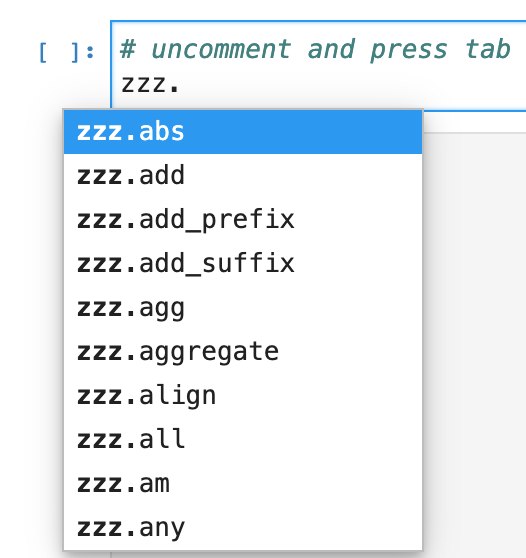

</div>

### Option 2: monkey patching siuba.siu.Symbolic

Finally, you could imagine that we replace some part of the Symbolic class, so that it does the autocomplete. This is shown below (using a new class rather than monkey patching).

In [12]:
from siuba.siu import Symbolic
from siuba.data import mtcars

class Symbolic2(Symbolic):
    def __dir__(self):
        return dir(mtcars)

However, a problem here is that when Jedi completes on a DataFrame (vs something with a `__dir__` method that spits out DataFrame info), it can add type information. With the `__dir__` method, Jedi does not know we want it to think of Symbolic2 as a DataFrame.

In [13]:
bbb = Symbolic2()

from siuba import _
import jedi
interpreter = jedi.Interpreter('bbb.', [{'bbb': bbb, 'mtcars': mtcars}])

completions = list(interpreter.complete())

entry = completions[0]
entry.name, entry.type

('abs', 'instance')

This is why in the output above it doesn't know that `abs` is a function, so reports it as an instance.

### Option 3: monkey patching `IPython.Completer._jedi_matches`

This approach is similar to the above, where we replace `_` in the Completer's namespace with the target DataFrame. However, we do the replacement by manually copying the code of the `_jedi_matches` method, and making the replacement at the very beginning.


Alternatively, you could just wrap _jedi_matches to change `shell.Completer.namespace` as in the hook example.

In [14]:
import types

from functools import wraps
from siuba.data import mtcars
from siuba import _

# using aaa for this example
aaa = _

def _jedi_matches_wrapper(obj):
    f = obj._jedi_matches
    @wraps(f)
    def wrapper(self, *args, **kwargs):
        # store old namespace (should be context manager)
        old_ns = self.namespace
        
        target_df = self.namespace["mtcars"]
        self.namespace = {**old_ns, "aaa": target_df}
        
        res = f(*args, **kwargs)
        
        # set namespace back
        self.namespace = old_ns
        
        # return results
        return res
        
    return types.MethodType(wrapper, obj)

#shell = get_ipython()
#shell.Completer._jedi_matches = _jedi_matches_wrapper(shell.Completer)

In [15]:
from IPython.core.completer import IPCompleter, provisionalcompleter

shell = get_ipython()
completer = IPCompleter(shell, shell.user_ns)

completer._jedi_matches = _jedi_matches_wrapper(shell.Completer)

with provisionalcompleter():
    completions = list(completer.completions('aaa.', 4))

completions[:3]

[<Completion start=4 end=4 text='abs' type='function', signature='()',>,
 <Completion start=4 end=4 text='add' type='<unknown>', signature='?',>,
 <Completion start=4 end=4 text='add_prefix' type='<unknown>', signature='?',>]

Alternatively, you could manually copy the `_jedi_matches` function, and modify it to pass the edited namespace instead.

```python
def _jedi_matches(self, cursor_column:int, cursor_line:int, text:str) -> Iterable[Any]:
    # THIS CONTENT IS INSERTED ----
    # do namespace stuff...
    
    # THIS CONTENT ORIGINAL ----
    # do original stuff in function

shell = get_ipython()
if shell is not None:
    shell.Completer._jedi_matches = functools.partial(_jedi_matches, shell.Completer)

```

This has the advantage of not changing state on the Completer, but essentially locks us into using whatever `_jedi_matches` was when we copied it.

## Summary

Autocomplete for `_` that returns info about a DataFrame, requires two things.

1. Identifying what DataFrame the user has in mind
2. Implementing code around IPython's IPCompleter class.

For identifying the right DataFrame, we can use static analysis over a user's code history, along with python's built-in `ast` package.

For implementing the autocomplete itself, our best bet for now is to wrap `IPCompleter._jedi_matches`. In the long run it's worth opening an issue on IPython to discuss how we could get the colored type annotations without this kind of patch, or whether they know of better options!